# CartPole
https://blog.gofynd.com/building-a-deep-q-network-in-pytorch-fa1086aa5435
    
# Introduction
Cart Pole example of Reinforcement Learning.
We will first learn some new concepts and then 
we will apply Deep Learning to build a deep RL agent. 
We will then train this agent to balance the cart pole.

# The Cart Pole Balancing Problem
We will be using the CartPole-v0 environment provided by OpenAI GYM.

# Description
A pole is attached by an un-actuated joint to a cart, 
which moves along a frictionless track. 
The pendulum starts upright, and the goal is to prevent it 
from falling over by increasing 
and reducing the cart’s velocity.



# State Space
The observation of this environment is a four tuple :
    

# Action Space
There are just two possible actions: 
Left or Right, corresponding to the direction 
in which the agent can push the cart pole.
# Reward
The reward is 1 for every step taken, including the termination step.
# Starting State
All observations are assigned a uniform random value between ±0.05.
# Episode Termination
Pole Angle is more than ±12°
Cart Position is more than ±2.4 
(center of the cart reaches the edge of the display)
Episode length is greater than 200 (500 for v1).
# Solved Requirements
Considered solved when the average reward is greater than or 
equal to 195.0 over 100 consecutive trials.
# The Behavior of a Random Agent
We will first check the average reward that a random agent can earn. 
By Random Agent, I am referring to an agent selecting actions randomly, 
i.e, without using any environment information. 
Running this snippet gave an average reward of 23.3 in my case. 
It may vary slightly in your case. 
But still, the problem is far from solved.

In [2]:
# random_cartpole_agent.py
from torch import randint
import gym

rew_arr = []
episode_count = 100
env = gym.make('CartPole-v0')
for i in range(episode_count):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  randint(0,env.action_space.n,(1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
    rew_arr.append(rew)
    
print("average reward per episode :",sum(rew_arr)/ len(rew_arr))

average reward per episode : 23.3


# Question:
Consider the following interaction between Agent and Environment.
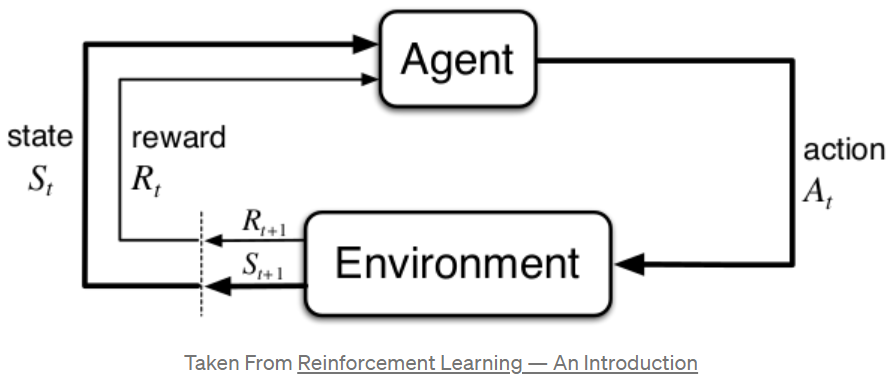
Based on the received observations and rewards from the environment, 
the agent selects some action. 
The agent must have some policy (aka, strategy) according to 
which it selects an action. 
Just having a policy is not enough, the agent must have a mechanism 
to improve this strategy as it interacts more and more with the environment. 
Now (some of) the questions are:
1. How to represent a policy?
2. How to evaluate the current policy (Policy Evaluation)?
3. How to improve the policy (Policy Improvement )?

# Deep Learning
We will be using the deep neural networks as function approximators. 
In the absence of deep neural network, to apply these algorithms 
we would need to store a table of dimension S x A 
where S is the number of possible states and 
A is the number of actions that can be taken in the environment. 
Even with a simple environment, this table is too large to be 
usable in practice.
Let us see how we can use Deep Learning to address the above concerns:
1. In DL, we use neural networks as function approximators.
We can represent our policy via Deep NN.
This NN will look at the given observation and will tell us 
which action is best to take in the current state. 
We refer to such Deep Neural Networks as Policy Network.
2. By policy evaluation, we mean to check how "good" or "impactful" is 
our current policy. 
The loss of Policy Network can be used to check this. 
In this discussion, we will use the Mean Squared Error between predicted 
and target returns to evaluate our policy network.
3. The Policy Evaluation step gives us the loss value of the 
current policy network. 
With this information, we can use Gradient Descent to optimize 
the weights of the policy network to minimize this loss. 
In this way, the policy network can be improved.

# Deep Q-Network
A DQN is a Q-value function approximator. 
At each time step, we pass the current environment observations as input. 
The output is the Q-value corresponding to each possible action.


# Where are the ground truths?
In Supervised Learning, we have a ground truth corresponding to 
each input data point. 
The network prediction can be compared against the corresponding 
ground truth to evaluate its performance. 
But here we do not have the ground truths or at least not in the popular sense.
In most cases, we do not have the exact dynamics of the environment. 
That means we do not exactly know the value of selecting an action 
in a state even if the environment dynamics are known, 
then we would need to run the agent-environment interaction 
for a sufficiently long time or ideally until the end of the episodes. 
Then we can go back and update the ground-truth value. 
Note that this also means that we would need to store 
the entire sequence of interaction which is not feasible in most scenarios.

# Discounted Returns as Ground Truth
The value of taking action $a$ in state $s$, i.e., $q(s, a)$ can be written as :

$$ q(s(t), a(t) ) = R(t) + γ * R(t+1) + γ² * R(t+2) + γ³ * R(t+3) + ……$$

where $γ$ is the discount factor, 
the value of which belongs to the interval [0,1]. 
The idea here is that we care not only for the immediate rewards 
but also for the future rewards that can result after taking this action.

The discount rate determines the present value of future rewards:
a reward received $k$ time steps in the future is worth only $pow(γ ,k-1)$
times what it would be worth if it were received immediately.
With a bit rearrangement, the above equation can be simplified to:

$$q(s(t), a(t)) = R(t) + γ * MAX\_OVER\_ACTION [q(s(t+1), a)]$$

# Training Algorithm
Step-1: Initialize game state and get initial observations.

Step-2: Input the observation (obs) to Q-network and get Q-value 
    corresponding to each action. Store the maximum of the q-value in X.

Step-3: With a probability, epsilon selects random action, otherwise,
    select action corresponding to max q-value. 

Step-4: Execute the selected action in the game state and 
    collect the generated reward(r(t)) and next state observation(obs_next).
Step-5: Pass these next state observation through Q-network and 
    store the maximum of these Q-values in a variable say q_next_state. 
    If the discount factor is Gamma then the ground truth can be calculated as:

$$Y = r(t) + Gamma * q\_next\_state$$

Step-6: Take X as the predicted return of current state and Y as the 
actual return. Calculate loss and perform an optimization step.

Step-7: Set obs = obs_next.

Step-8: Repeat Step-2 to Step-7 for n episodes.

# Balance Exploration vs Exploitation
In the beginning, our agent has no idea of the environment dynamics. 
So, we should let it explore and as it interacts with the environment and 
it should increasingly exploit its learning along with exploration. 
There is a need to balance this exploration and exploitation. 
We can either choose the action corresponding to maximum Q-value(exploitation) or with a small probability, epsilon, a random action can be selected(exploration). In this agent’s training, we started with epsilon = 1, 
i.e., 100% exploration and slowly decrease it to 0.05.

# Catastrophic (Disastrous) Forgetting and Need For Replay Buffer
There is a serious issue with the above training process. 
After each step of agent-environment interaction, 
we are performing an optimization step. 
This can lead to catastrophic forgetting.

Today’s deep learning methods struggle to learn rapidly in the incremental, 
online settings that are most natural for the reinforcement learning algorithms. 
The problem is sometimes described as one of "catastrophic interference" or 
"correlated data."

When something new is learned it tends to replace what has previously been 
learned rather than adding to it, with the result that the benefit of 
the older learning is lost. 
Techniques such as "replay buffers" are often used to retain and 
replay old data so that its benefits are not permanently lost.

So as you might have guessed by now, we will be using replay buffers 
to address this problem. 
The agent will gather the experience in replay buffer and 
then a random batch of experience will be sampled from this buffer. 
This batch will be used for training the agent using mini-batch 
gradient descent.

# Training Instability and Need for Two Identical Q-Network
Until now, the same Q-network is used for predicting the Q-value of 
the current state and next state. 

The Q-value of the next state is then used to calculate ground truth. 
In simple words, we executed our optimization step to bring the 
prediction close to ground truth but at the same time we are changing 
the weights of the network which gave us the ground truth.

This causes instability in training. The solution is to have another 
network called Target Network which is an exact copy of the Main Network.

This target network is used to generate target values or ground truth. 
The weights of this network are held fixed for a fixed number of 
training steps after which these are updated with the weight of Main Network. 

In this way, the distribution of our target return is also held fixed 
for some fixed iterations which increase training stability.
Also, note that we are using the term policy network and 
q-network almost interchangeably but these are two different types of networks. 

Given a state, a policy network generates a probability distribution over 
actions while a Q-network generates Q-values corresponding to every action.

# Coding of DQN Agent
It seems quite natural to wrap our agent in a class. 
The agent receives state observations and rewards from the environment. 
It then acts on the environment based on current observation. 
The Deep Q-Network is the brain of our agent. 
The agent learns from interactions and 
adjusts the weight of Q-network accordingly. 

Let us quickly go through the code:
The init function builds two identical deep neural networks. 
Before that we first seed torch random generator. 
In this way, the weights of the neural network are 
initialized deterministically.

Remove all occurrences of ".cuda()"" from this code if you do not have 
Cuda support on your machine.

The variable network_sync_freq donate the number of training steps to 
take before updating the target network with the weight of the main network. 

The variable network_sync_counter is incremented after each training step 
in train() function and is reset to 0 when it reaches network_sync_freq. 

The variable experience_replay is a deque. 
In train() function, the Q-value of the current state is estimated using 
Main Q-Network. 

The Q-value of the next state is calculated using Target Network, 
which is then used to calculate the target return.

The rest of the code is pretty much self-explanatory.

In [3]:
# DQN_Agent.py
import torch
from torch import nn
import copy
from collections import deque
import random

class DQN_Agent:
    
    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.q_net = self.build_nn(layer_sizes)
        self.target_net = copy.deepcopy(self.q_net)
        # self.q_net.cuda()
        # self.target_net.cuda()
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.network_sync_freq = sync_freq
        self.network_sync_counter = 0
        # self.gamma = torch.tensor(0.95).float().cuda()
        self.gamma = torch.tensor(0.95).float()
        self.experience_replay = deque(maxlen = exp_replay_size)  
        return
        
    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            act =    nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()
            layers += (linear,act)
        return nn.Sequential(*layers)
    
    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            # Qp = self.q_net(torch.from_numpy(state).float().cuda())
            Qp = self.q_net(torch.from_numpy(state).float())
        Q,A = torch.max(Qp, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0,action_space_len,(1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            qp = self.target_net(state)
        q,_ = torch.max(qp, axis=1)    
        return q
    
    def collect_experience(self, experience):
        self.experience_replay.append(experience)
        return
    
    def sample_from_experience(self, sample_size):
        if(len(self.experience_replay) < sample_size):
            sample_size = len(self.experience_replay)   
        sample = random.sample(self.experience_replay, sample_size)
        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()   
        return s, a, rn, sn
    
    def train(self, batch_size ):
        s, a, rn, sn = self.sample_from_experience( sample_size = batch_size)
        if(self.network_sync_counter == self.network_sync_freq):
            self.target_net.load_state_dict(self.q_net.state_dict())
            self.network_sync_counter = 0
        
        # predict expected return of current state using main network
        # qp = self.q_net(s.cuda())
        qp = self.q_net(s)
        pred_return, _ = torch.max(qp, axis=1)
        
        # get target return using target network
        # q_next = self.get_q_next(sn.cuda())
        q_next = self.get_q_next(sn)
        # target_return = rn.cuda() + self.gamma * q_next
        target_return = rn + self.gamma * q_next
        
        loss = self.loss_fn(pred_return, target_return)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        
        self.network_sync_counter += 1       
        return loss.item()

# main program (main.py)

We first initialize both environment and agent.
Then the replay buffer is filled to its full capacity, 256 in this case.
Then we fix it for 4 training steps and during each training step, 
a batch of length 16 is sampled randomly from this buffer. 

Then the agent interacts with the environment for the next 128 time steps and 
collects the experience in the buffer. 

Note that since it is a deque after it is filled to its full capacity (which we do before the main training loop), with each new experience inserted into it, one element from the front is also removed.
To balance exploration and exploitation, we are using the epsilon-greedy 
strategy. 

We first promote full exploration by setting epsilon = 1 and 
update it after each episode to slowly decrease it to 0.05.

In [6]:
# main.py
# from dqn_agent import DQN_Agent
import gym
from tqdm import tqdm

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
exp_replay_size = 256
agent = DQN_Agent(seed = 1423, layer_sizes = [input_dim, 64, output_dim], lr = 1e-3, sync_freq = 5, exp_replay_size = exp_replay_size)

# initiliaze experiance replay      
index = 0
for i in range(exp_replay_size):
    obs = env.reset()
    done = False
    while(done != True):
        A = agent.get_action(obs, env.action_space.n, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
        obs = obs_next
        index += 1
        if( index > exp_replay_size ):
            break
            
# Main training loop
losses_list, reward_list, episode_len_list, epsilon_list  = [], [], [], []
index = 128
episodes = 10000
epsilon = 1

for i in tqdm(range(episodes)):
    obs, done, losses, ep_len, rew = env.reset(), False, 0, 0, 0
    while(done != True):
        ep_len += 1 
        A = agent.get_action(obs, env.action_space.n, epsilon)
        obs_next, reward, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), reward, obs_next])
       
        obs = obs_next
        rew  += reward
        index += 1
        
        if(index > 128):
            index = 0
            for j in range(4):
                loss = agent.train(batch_size=16)
                losses += loss      
    if epsilon > 0.05 :
        epsilon -= (1 / 5000)
    
    losses_list.append(losses/ep_len), reward_list.append(rew), episode_len_list.append(ep_len), epsilon_list.append(epsilon)

  0%|                                                                         | 0/10000 [00:00<?, ?it/s]<ipython-input-5-fdb4f63c3401>:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  s = torch.tensor([exp[0] for exp in sample]).float()
100%|█████████████████████████████████████████████████████████████| 10000/10000 [03:54<00:00, 42.64it/s]


# Plots
1. This plot shows how reward varies as we make progress in training. 
Roughly after 6500 episodes, it scores maximum in each episode.
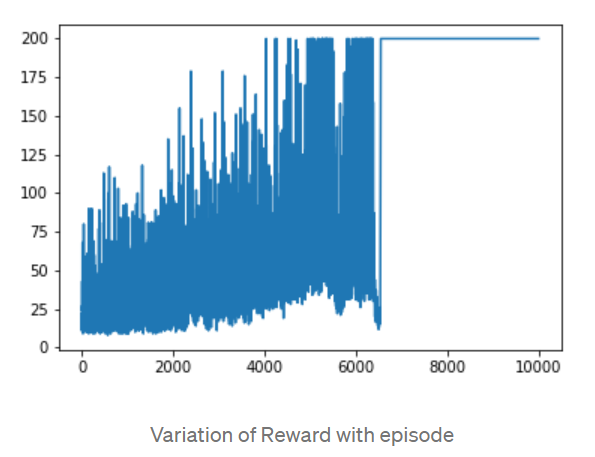
2. This plot shows the variation in loss value as the training progress.
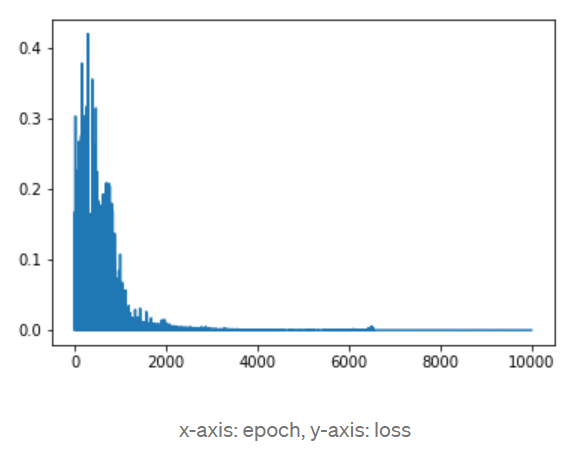
3. This plot shows the variation of epsilon as the training progress.


# Balance Cart Pole 

The trained agent is balancing the cart pole. 

The Pole almost appears to be still. 

It scored the maximum score each time I tried. 

Although taking the average over a large number of episodes is 
a much better idea.
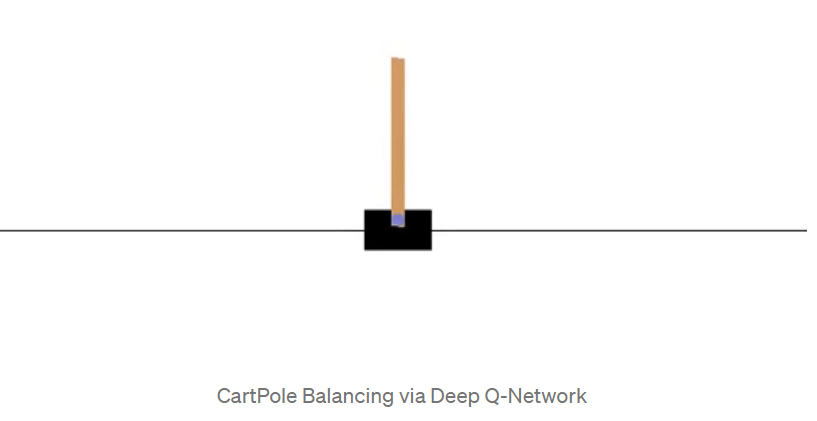

In [ ]:
# dqn_agent_demo.py
import gym
from tqdm import tqdm
from time import sleep
# from dqn_agent import DQN_Agent

env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, "record_dir")
for i in tqdm(range(2)):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  agent.get_action(obs, env.action_space.n, epsilon = 0)
        obs, reward, done, info = env.step(A.item())
        rew += reward
        sleep(0.01)
        env.render()  
    print("episode : {}, reward : {}".format(i,rew)) 

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]